## MODEL Building (Under sampling dataset)

In [1]:
#importing modules
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import precision_score, recall_score, classification_report, f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import roc_curve,  auc

import warnings
warnings.filterwarnings('ignore')

In [2]:
#importing under sampling dataset
train_df = pd.read_csv(Path('Resources/cleaned-data/2019loans_us.csv'))
test_df = pd.read_csv(Path('Resources/cleaned-data/2020Q1loans_us.csv'))

In [3]:
# looking train data
train_df.head()

,loan_amnt,int_rate,installment,annual_inc,home_ownership,verification_status,pymnt_plan,dti,delinq_2yrs,inq_last_6mths,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag,loan_status
0,7000.0,0.1894,256.38,75000.0,MORTGAGE,Not Verified,n,28.62,0.0,2.0,...,87.5,0.0,0.0,352260.0,62666.0,35000.0,10000.0,N,N,low_risk
1,40000.0,0.1614,975.71,102000.0,MORTGAGE,Source Verified,n,11.72,2.0,0.0,...,0.0,0.0,0.0,294664.0,109911.0,9000.0,71044.0,N,N,low_risk
2,11000.0,0.2055,294.81,45000.0,RENT,Verified,n,37.25,1.0,3.0,...,7.7,0.0,0.0,92228.0,36007.0,33000.0,46328.0,N,N,low_risk
3,4000.0,0.1612,140.87,38000.0,MORTGAGE,Not Verified,n,42.89,1.0,0.0,...,100.0,0.0,0.0,284273.0,52236.0,13500.0,52017.0,N,N,low_risk
4,14000.0,0.1797,505.93,43000.0,MORTGAGE,Source Verified,n,22.16,1.0,0.0,...,25.0,0.0,0.0,120280.0,88147.0,33300.0,78680.0,N,N,low_risk


In [92]:
train_df["home_ownership"].value_counts()

MORTGAGE    5708
RENT        4966
OWN         1441
ANY           65
Name: home_ownership, dtype: int64

In [93]:
# looking test data
test_df.head()

,loan_amnt,int_rate,installment,annual_inc,home_ownership,verification_status,pymnt_plan,dti,delinq_2yrs,inq_last_6mths,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag,loan_status
0,40000.0,0.1033,856.40,128700.0,RENT,Source Verified,n,12.47,0.0,1.0,...,57.1,0.0,0.0,63915.0,49510.0,49400.0,14515.0,Y,N,low_risk
1,24450.0,0.1430,572.72,44574.0,MORTGAGE,Not Verified,n,15.05,0.0,1.0,...,0.0,0.0,0.0,136425.0,19439.0,15500.0,18925.0,N,N,low_risk
2,13500.0,0.1430,316.23,60000.0,OWN,Not Verified,n,28.72,0.0,0.0,...,0.0,0.0,0.0,82124.0,65000.0,5400.0,61724.0,Y,N,low_risk
3,10625.0,0.1774,268.31,60000.0,RENT,Verified,n,15.70,0.0,4.0,...,20.0,0.0,0.0,54855.0,50335.0,23200.0,26255.0,N,N,low_risk
4,6375.0,0.1862,232.46,60000.0,RENT,Source Verified,n,35.50,0.0,0.0,...,75.0,0.0,0.0,90445.0,56541.0,15300.0,72345.0,N,N,low_risk


In [94]:
train_df.columns

Index(['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'home_ownership',
       'verification_status', 'pymnt_plan', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'collections_12_mths_ex_med', 'policy_code',
       'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m',
       'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m',
       'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi',
       'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal',
       'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt',
       'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'm

In [95]:
#shape of training data
train_df.shape

(12180, 84)

In [96]:
#shape of test data
test_df.shape

(4702, 84)

In [97]:
#train_df.info()

#removing unnessary columns from training and testing set
train_df.drop(columns=['Unnamed: 0', 'index'], inplace=True)
test_df.drop(columns=['Unnamed: 0', 'index'], inplace=True)

In [10]:
train_df['loan_status'].value_counts()

low_risk     6090
high_risk    6090
Name: loan_status, dtype: int64

## Train and test set

In [11]:
# create feature matrix (X) #selecting all columns except 'loan_status'
X_train=train_df.drop('loan_status', axis=1) 
X_test=test_df.drop('loan_status', axis=1) 

# create response vector (y) ##selecting 'loan_status'
y_train=train_df['loan_status'].values  
y_test=test_df['loan_status'].values  

In [12]:
y_train

array(['low_risk', 'low_risk', 'low_risk', ..., 'high_risk', 'high_risk',
       'high_risk'], dtype=object)

## Converting categorical data to numeric

In [13]:
# Convert categorical data to numeric
X_train_dumy=pd.get_dummies(X_train)
X_test_dumy=pd.get_dummies(X_test)

In [14]:
#shape of test and train after pd.get_dummies
print(X_train_dumy.shape)
print(X_test_dumy.shape)

(12180, 92)
(4702, 91)


In [15]:
#adding the missing columns in test data(no dept_settlement_flag)
X_test_dumy['debt_settlement_flag_Y']=0

In [16]:
#shape of test and train after pd.get_dummies
print(X_train_dumy.shape)
print(X_test_dumy.shape)

(12180, 92)
(4702, 92)


In [17]:
#train_list=X_train_dumy.values.tolist()
#test_list=X_test_dumy.values.tolist()


## Scaling using StandardScalar

In [18]:
 # Converting output labels to 0 and 1
y_train_label = LabelEncoder().fit_transform(y_train)
y_train=y_train_label
y_train

array([1, 1, 1, ..., 0, 0, 0])

In [19]:
 # Converting output labels to 0 and 1
y_test_label = LabelEncoder().fit_transform(y_test)
y_test=y_test_label

In [20]:
# Create a StandardScaler() model and fit it to the training data
X_scaler = StandardScaler().fit(X_train_dumy)


In [21]:
# Transform the training and testing data by using the X_scaler and y_scaler models
X_train_scaled = X_scaler.transform(X_train_dumy)
X_test_scaled = X_scaler.transform(X_test_dumy)


In [22]:
#shape of test and train after standard scalar
print(X_train_scaled.shape)
print(X_test_scaled.shape)

(12180, 92)
(4702, 92)


## LogisticRegression

In [23]:
# Creating a Logistic Regression model on the scaled data
lr= LogisticRegression()

# Fit the model to the data
lr.fit(X_train_scaled, y_train)

LogisticRegression()

In [24]:
#printing the accuracy score
print(f'Training Score: {lr.score(X_train_scaled, y_train)}')
print(f'Testing Score: {lr.score(X_test_scaled, y_test)}')

Training Score: 0.710919540229885
Testing Score: 0.7598894087622289


In [25]:
#score of training set using cross_val_score
cross_val_score(lr, X_train_scaled, y_train, cv=5, scoring='accuracy')

array([0.6818555 , 0.67364532, 0.7089491 , 0.72003284, 0.70648604])

In [26]:
#predection on the train set and confusion matrix
#cross_val_predict performs k-fold cross-validation but instead of returning evaluation scores it return the prediction made in each fold.
y_train_pred=cross_val_predict(lr, X_train_scaled, y_train, cv=5)
confusion_matrix(y_train, y_train_pred)

array([[3866, 2224],
       [1452, 4638]])

In [27]:
#predection on the test set and confusion matrix
y_pred=lr.predict(X_test_scaled)
confusion_matrix(y_test, y_pred)

array([[1764,  587],
       [ 542, 1809]])

In [28]:
#classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.75      0.76      2351
           1       0.76      0.77      0.76      2351

    accuracy                           0.76      4702
   macro avg       0.76      0.76      0.76      4702
weighted avg       0.76      0.76      0.76      4702



In [29]:
#roc curve
y_proba_lr = lr.predict_proba(X_test_scaled)[:,1]  #proba of positive class
fpr, tpr, thresholds = roc_curve(y_test_label, y_proba_lr)

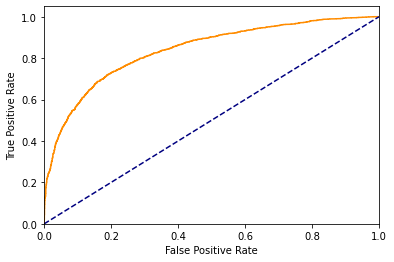

In [30]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [31]:
# area under the curve (AUC)
roc_auc = auc(fpr, tpr)
roc_auc

0.8379492622034189

## KNeighbors Classifier

In [ ]:
knn=KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled, y_train)

In [ ]:
#printing the accuracy score
print(f'Training Score: {knn.score(X_train_scaled, y_train)}')
print(f'Testing Score: {knn.score(X_test_scaled, y_test)}')

In [ ]:
# Loop through different k values to find which has the highest accuracy.
train_scores = []
test_scores = []
for k in range(1, 20, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    train_score = knn.score(X_train_scaled, y_train)
    test_score = knn.score(X_test_scaled, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    

In [ ]:
#plotting knn scores
plt.plot(range(1, 20, 2), train_scores, marker='o')
plt.plot(range(1, 20, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.show()

In [ ]:
 # Note that k: 7 provides the best accuracy where the classifier starts to stablize
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train_scaled, y_train)
print('k=5 Test Acc: %.3f' % knn.score(X_test_scaled, y_test))

In [ ]:
#score of training set using cross_val_score
cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy')

In [ ]:
#predection on the train set and confusion matrix
#cross_val_predict performs k-fold cross-validation but instead of returning evaluation scores it return the prediction made in each fold.
y_train_pred=cross_val_predict(knn, X_train_scaled, y_train, cv=5)
confusion_matrix(y_train, y_train_pred)

In [ ]:
#predection on the test set and confusion matrix
y_pred_knn=lr.predict(X_test_scaled)
confusion_matrix(y_test, y_pred_knn)

In [ ]:
#classification report
print(classification_report(y_test, y_pred_knn))

In [ ]:
#roc curve
y_pred_proba = knn.predict_proba(X_test_scaled)[:,1]  #proba of positive class
fpr, tpr, thresholds = roc_curve(y_test_label, y_pred_proba)

In [ ]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [ ]:
# area under the curve (AUC)
roc_auc = auc(fpr, tpr)
roc_auc

## Support Vector Classifier

In [ ]:
# Support vector machine linear classifier
svc=SVC(kernel='linear', probability=True)
svc.fit(X_train_scaled, y_train)

In [ ]:
#printing the accuracy score
print(f'Training Score: {svc.score(X_train_scaled, y_train)}')
print(f'Testing Score: {svc.score(X_test_scaled, y_test)}')

In [ ]:
#predection on the test set and confusion matrix
y_pred_svc=svc.predict(X_test_scaled)
confusion_matrix(y_test, y_pred_svc)

In [ ]:
#classification report
print(classification_report(y_test, y_pred_svc))

In [ ]:
#roc curve
y_proba_svc = svc.predict_proba(X_test_scaled)[:,1]  #proba of positive class
fpr, tpr, thresholds = roc_curve(y_test_label, y_proba_svc)

In [ ]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [ ]:
# area under the curve (AUC)
roc_auc = auc(fpr, tpr)
roc_auc

### Tuning hyperparamaters  using Grid Search CV

In [ ]:
#### Using GridSearchCV
param_grid = {'C': [1, 5, 10],
              'gamma': [0.0001, 0.001, 0.005]}
grid_svc = GridSearchCV(svc, param_grid, cv=3, verbose=1, n_jobs=-1)

In [ ]:
grid_svc.fit(X_train_scaled, y_train)

In [ ]:
# List the best parameters for this dataset
print(grid_svc.best_params_)

In [ ]:
# List the best score
print(grid_svc.best_score_)

In [ ]:
#best estimator
svc_b=grid_svc.best_estimator_
svc_b

In [ ]:
# Score the hypertuned model on the test dataset
svc_b.score(X_test_scaled, y_test)

In [ ]:
# Make predictions with the hypertuned model
pred = svc_b.predict(X_test_scaled)
confusion_matrix(y_test, pred)

In [ ]:
#classification report
print(classification_report(y_test, pred))

### Tuning hyperparamaters  using Randomized Search CV

In [ ]:
#### Using RandomizedSearchCV
param_rand = {
    'C' : np.arange(0, 100, 1),
    'gamma': np.arange(0, 0.01, .0001),
}
rand_svc = RandomizedSearchCV(svc, param_rand, cv=3, n_iter=100, random_state=1, verbose=1, n_jobs=-1)

In [ ]:
rand_svc.fit(X_train_scaled, y_train)

In [ ]:
# List the best parameters for this dataset
print(rand_svc.best_params_)

In [ ]:
# List the best score
print(rand_svc.best_score_)

In [ ]:
#best estimator
svc_best=rand_svc.best_estimator_
svc_best

In [ ]:
# Score the hypertuned model on the test dataset
svc_best.score(X_test_scaled, y_test)

In [ ]:
# Make predictions with the hypertuned model
predic = svc_best.predict(X_test_scaled)
confusion_matrix(y_test, predic)

In [ ]:
#classification report
print(classification_report(y_test, predic))

## Decision Tree 

In [32]:
dt = DecisionTreeClassifier()
dt.fit(X_train_scaled, y_train)

DecisionTreeClassifier()

In [33]:
#printing the accuracy score
print(f'Training Score: {dt.score(X_train_scaled, y_train)}')
print(f'Testing Score: {dt.score(X_test_scaled, y_test)}')

Training Score: 1.0
Testing Score: 0.48553806890684814


In [34]:
#predection on the test set and confusion matrix
y_pred_dt=dt.predict(X_test_scaled)
confusion_matrix(y_test, y_pred_dt)

array([[1383,  968],
       [1451,  900]])

In [35]:
#classification report
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.49      0.59      0.53      2351
           1       0.48      0.38      0.43      2351

    accuracy                           0.49      4702
   macro avg       0.48      0.49      0.48      4702
weighted avg       0.48      0.49      0.48      4702



[9.30076541e-03 1.88348735e-02 6.14576252e-02 1.22818801e-02
 1.58908251e-02 1.89769756e-03 3.35968142e-03 3.80198823e-03
 1.75304294e-03 1.20560651e-02 8.08612967e-03 2.40679930e-02
 2.25860043e-02 1.62023868e-02 1.86265550e-02 1.10645640e-01
 8.95652290e-02 2.85323874e-02 0.00000000e+00 0.00000000e+00
 1.69504482e-01 1.15425851e-03 0.00000000e+00 0.00000000e+00
 3.14330194e-03 1.15820690e-02 2.98796693e-03 5.72427668e-03
 2.55427906e-03 5.80386773e-03 1.10057771e-02 8.52247245e-03
 1.09776983e-02 3.01328080e-03 6.81766279e-03 7.22843839e-03
 1.18442690e-02 8.62116148e-03 7.98015968e-03 5.04052424e-03
 3.98297258e-03 9.61390518e-03 1.26945228e-02 1.24127436e-02
 9.76176257e-03 5.69027645e-04 0.00000000e+00 1.69497248e-02
 1.70745186e-02 9.98871153e-03 1.08038417e-02 5.70368082e-03
 9.49871376e-03 7.85014248e-03 3.45511309e-03 1.46696044e-03
 4.03104550e-03 5.86254451e-03 3.09152616e-03 9.45549354e-03
 3.45538698e-03 7.91485799e-03 5.05201457e-03 6.91358997e-03
 0.00000000e+00 0.000000

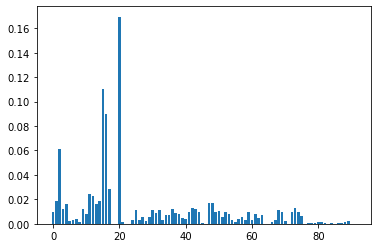

In [36]:
features_dt = dt.feature_importances_
print(features_dt)
plt.bar(x = range(len(features_dt)), height=features_dt)
plt.show()

In [37]:
#roc curve
y_proba_tree = dt.predict_proba(X_test_scaled)[:,1]  #proba of positive class
fpr, tpr, thresholds = roc_curve(y_test_label, y_proba_tree)

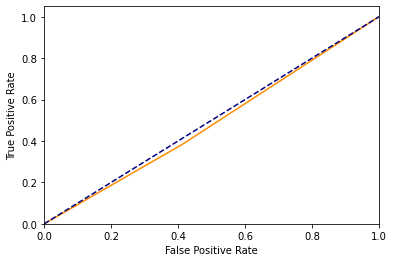

In [38]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [39]:
# area under the curve (AUC)
roc_auc = auc(fpr, tpr)
roc_auc

0.48553806890684814

### Tuning hyperparamaters  using Grid Search CV for Decision Tree

In [40]:
#### Using GridSearchCV
param_grid_dt = {
              'criterion': ['gini','entropy'],
             'max_depth':[1,2,5,10,100,1000,10000],
                'min_samples_leaf':[1,5,10,100,1000,10000],
                'max_features':['auto','sqrt','log2']}
grid_dt = GridSearchCV(dt, param_grid_dt, cv=3, verbose=1, n_jobs=-1)

In [41]:
grid_dt.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 252 candidates, totalling 756 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 5, 10, 100, 1000, 10000],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 5, 10, 100, 1000, 10000]},
             verbose=1)

In [42]:
# List the best parameters for this dataset
print(grid_dt.best_params_)

{'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'min_samples_leaf': 100}


In [43]:
# List the best score
print(grid_dt.best_score_)

0.702463054187192


In [44]:
#best estimator
dt_b=grid_dt.best_estimator_
dt_b

DecisionTreeClassifier(max_depth=100, max_features='auto', min_samples_leaf=100)

In [45]:
# Score the hypertuned model on the test dataset
dt_b.score(X_test_scaled, y_test)

0.5710336027222459

In [46]:
# Make predictions with the hypertuned model
pred_dt = dt_b.predict(X_test_scaled)
confusion_matrix(y_test, pred_dt)

array([[1346, 1005],
       [1012, 1339]])

In [47]:
#classification report
print(classification_report(y_test, pred_dt))

              precision    recall  f1-score   support

           0       0.57      0.57      0.57      2351
           1       0.57      0.57      0.57      2351

    accuracy                           0.57      4702
   macro avg       0.57      0.57      0.57      4702
weighted avg       0.57      0.57      0.57      4702



### Tuning hyperparamaters  using Randomized Search CV for Decision Tree

In [48]:
#### Using GridSearchCV
param_rand_dt ={
              'criterion': ['gini','entropy'],
             'max_depth':[1,2,5,10,100,1000,10000],
                'min_samples_leaf':[1,5,10,100,1000,10000],
                'max_features':['auto','sqrt','log2']}
rand_dt = RandomizedSearchCV(dt, param_rand_dt, cv=3, verbose=4, n_jobs=-1)

In [49]:
rand_dt.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 2, 5, 10, 100, 1000,
                                                      10000],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 5, 10, 100,
                                                             1000, 10000]},
                   verbose=4)

In [50]:
# List the best parameters for this dataset
print(rand_dt.best_params_)

{'min_samples_leaf': 100, 'max_features': 'sqrt', 'max_depth': 10000, 'criterion': 'gini'}


In [51]:
# List the best score
print(rand_dt.best_score_)

0.6629720853858785


In [52]:
#best estimator
dt_R_b=rand_dt.best_estimator_
dt_R_b

DecisionTreeClassifier(max_depth=10000, max_features='sqrt',
                       min_samples_leaf=100)

In [53]:
# Score the hypertuned model on the test dataset
dt_R_b.score(X_test_scaled, y_test)

0.5240323266695024

In [54]:
# Make predictions with the hypertuned model
pred_dtr = dt_R_b.predict(X_test_scaled)
confusion_matrix(y_test, pred_dtr)

array([[1198, 1153],
       [1085, 1266]])

In [55]:
#classification report
print(classification_report(y_test, pred_dtr))

              precision    recall  f1-score   support

           0       0.52      0.51      0.52      2351
           1       0.52      0.54      0.53      2351

    accuracy                           0.52      4702
   macro avg       0.52      0.52      0.52      4702
weighted avg       0.52      0.52      0.52      4702



## Bagging

## a. Random Forest Classifier
Instead of having one decision tree, we make more random trees and average their output.

In [56]:
#Random Forest classifier model
rf=RandomForestClassifier(random_state=1, n_estimators=500)
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(n_estimators=500, random_state=1)

In [57]:
#printing the accuracy score
print(f'Training Score: {rf.score(X_train_scaled, y_train)}')
print(f'Testing Score: {rf.score(X_test_scaled, y_test)}')

Training Score: 1.0
Testing Score: 0.6480221182475542


In [58]:
#score of training set using cross_val_score
cross_val_score(rf, X_train_scaled, y_train, cv=5, scoring='accuracy')

array([0.65640394, 0.75410509, 0.80541872, 0.83045977, 0.81609195])

In [59]:
#predection on the train set and confusion matrix
#cross_val_predict performs k-fold cross-validation but instead of returning evaluation scores it return the prediction made in each fold.
y_train_pred=cross_val_predict(rf, X_train_scaled, y_train, cv=5)
confusion_matrix(y_train, y_train_pred)

array([[4609, 1481],
       [1290, 4800]])

In [60]:
#predection on the test set and confusion matrix
y_pred_rf=rf.predict(X_test_scaled)
confusion_matrix(y_test, y_pred_rf)

array([[1960,  391],
       [1264, 1087]])

In [61]:
#classification report
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.61      0.83      0.70      2351
           1       0.74      0.46      0.57      2351

    accuracy                           0.65      4702
   macro avg       0.67      0.65      0.64      4702
weighted avg       0.67      0.65      0.64      4702



[1.64175246e-02 3.36047005e-02 3.07032294e-02 1.42239163e-02
 1.54887781e-02 2.97922850e-03 4.27051795e-03 8.55840612e-03
 1.33532005e-03 1.51577257e-02 1.16142472e-02 2.95307776e-02
 2.99764667e-02 4.53332754e-02 4.48443196e-02 5.25173382e-02
 4.98329797e-02 1.62671260e-02 0.00000000e+00 0.00000000e+00
 9.97444637e-02 6.56760511e-04 0.00000000e+00 0.00000000e+00
 4.27868968e-03 1.34563223e-02 4.63160385e-03 6.58760719e-03
 4.03294385e-03 6.17692505e-03 1.18528253e-02 1.31099214e-02
 1.40812113e-02 5.12304140e-03 7.78349300e-03 1.53878110e-02
 1.33159958e-02 1.54529099e-02 5.98482161e-03 6.83047428e-03
 7.85674268e-03 9.78167759e-03 1.39355711e-02 1.55873811e-02
 1.40840046e-02 2.93482835e-04 0.00000000e+00 1.54613564e-02
 1.62359542e-02 1.18244670e-02 1.00680524e-02 5.67200574e-03
 1.29851695e-02 1.18672718e-02 3.62464457e-03 7.08920963e-03
 7.86624182e-03 7.36513040e-03 8.69878830e-03 1.01283162e-02
 8.34738211e-03 9.97869361e-03 7.97169822e-03 8.66230546e-03
 0.00000000e+00 0.000000

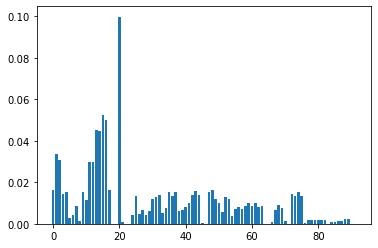

In [62]:
features_rf = rf.feature_importances_
print(features_rf)
plt.bar(x = range(len(features_rf)), height=features_rf)
plt.show()

In [63]:
#roc curve
y_proba_forest = rf.predict_proba(X_test_scaled)[:,1]  #proba of positive class
fpr, tpr, thresholds = roc_curve(y_test_label, y_proba_forest)

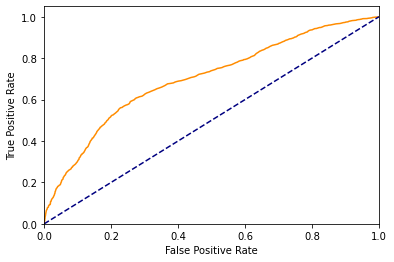

In [64]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [65]:
# area under the curve (AUC)
roc_auc = auc(fpr, tpr)
roc_auc

0.7009684467780347

### Tuning hyperparamaters  using Grid Search CV for Random Forest

In [ ]:
#### Using GridSearchCV
param_grid_rf = {'n_estimators':[100,200,500],
              'criterion': ['gini','entropy'],
             'max_depth':[1,2,5,10,100,1000,10000],
                'min_samples_leaf':[1,5,10,100,1000,10000],
                'max_features':['auto','sqrt','log2']}
grid_rf = GridSearchCV(rf, param_grid_rf, cv=3, verbose=1, n_jobs=-1)

In [ ]:
grid_rf.fit(X_train_scaled, y_train)

In [ ]:
# List the best parameters for this dataset
print(grid_rf.best_params_)

In [ ]:
# List the best score
print(grid_rf.best_score_)

In [ ]:
#best estimator
rf_b=grid_rf.best_estimator_
rf_b

In [ ]:
# Score the hypertuned model on the test dataset
rf_b.score(X_test_scaled, y_test)

In [ ]:
# Make predictions with the hypertuned model
pred_rf = rf_b.predict(X_test_scaled)
confusion_matrix(y_test, pred_rf)

In [ ]:
#classification report
print(classification_report(y_test, pred_rf))

### Tuning hyperparamaters  using Randomized Search CV for Random Forest

In [ ]:
#### Using GridSearchCV
param_rand_rf = {'n_estimators':[100,200,500],
              'criterion': ['gini','entropy'],
             'max_depth':[1,2,5,10,100,1000,10000],
                'min_samples_leaf':[1,5,10,100,1000,10000],
                'max_features':['auto','sqrt','log2']}
rand_rf = RandomizedSearchCV(rf, param_rand_rf, cv=3, verbose=1, n_jobs=-1)

In [ ]:
rand_rf.fit(X_train_scaled, y_train)

In [ ]:
# List the best parameters for this dataset
print(rand_rf.best_params_)

In [ ]:
# List the best score
print(rand_rf.best_score_)

In [ ]:
#best estimator
rf_R_b=rand_rf.best_estimator_
rf_R_b

In [ ]:
# Score the hypertuned model on the test dataset
rf_R_b.score(X_test_scaled, y_test)

In [ ]:
# Make predictions with the hypertuned model
pred_rfr = rf_R_b.predict(X_test_scaled)
confusion_matrix(y_test, pred_rfr)

In [ ]:
#classification report
print(classification_report(y_test, pred_rfr))

## b. Extremely Random Trees
Changing the behavior of the decision trees so that they randomly choose their splits

In [ ]:
et = ExtraTreesClassifier(random_state=1, n_estimators=500)
et.fit(X_train_scaled, y_train)

In [ ]:
#printing the accuracy score
print(f'Training Score: {et.score(X_train_scaled, y_train)}')
print(f'Testing Score: {et.score(X_test_scaled, y_test)}')

In [ ]:
#predection on the test set and confusion matrix
y_pred_et=et.predict(X_test_scaled)
confusion_matrix(y_test, y_pred_et)

In [ ]:
#classification report
print(classification_report(y_test, y_pred_et))

In [ ]:
features_et = et.feature_importances_
print(features_et)
plt.bar(x = range(len(features_et)), height=features_et)
plt.show()

In [ ]:
#roc curve
y_proba_rand_tree = et.predict_proba(X_test_scaled)[:,1]  #proba of positive class
fpr, tpr, thresholds = roc_curve(y_test_label, y_proba_rand_tree)

In [ ]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [ ]:
# area under the curve (AUC)
roc_auc = auc(fpr, tpr)
roc_auc

### Tuning hyperparamaters  using Grid Search CV for Extremely Random Tree

In [ ]:
#### Using GridSearchCV
param_grid_rt = {'n_estimators':[100,200,500],
              'criterion': ['gini','entropy'],
             'max_depth':[5,10,1000,10000],
                'min_samples_leaf':[10,100,1000,10000],
                'max_features':['auto','sqrt','log2']}
grid_rt = GridSearchCV(rt, param_grid_rt, cv=3, verbose=1, n_jobs=-1)

In [ ]:
grid_rt.fit(X_train_scaled, y_train)

In [ ]:
# List the best parameters for this dataset
print(grid_rt.best_params_)

In [ ]:
# List the best score
print(grid_rt.best_score_)

In [ ]:
#best estimator
rt_b=grid_rt.best_estimator_
rt_b

In [ ]:
# Score the hypertuned model on the test dataset
rt_b.score(X_test_scaled, y_test)

In [ ]:
# Make predictions with the hypertuned model
pred_rt = rt_b.predict(X_test_scaled)
confusion_matrix(y_test, pred_rt)

In [ ]:
#classification report
print(classification_report(y_test, pred_rt))

### Tuning hyperparamaters  using Randomized Search CV for Extremely Random Tree

In [ ]:
#### Using GridSearchCV
param_rand_rt = {'n_estimators':[100,200,500],
              'criterion': ['gini','entropy'],
             'max_depth':[5,10,1000,10000],
                'min_samples_leaf':[10,100,1000,10000],
                'max_features':['auto','sqrt','log2']}
rand_rt = RandomizedSearchCV(et, param_rand_rt, cv=3, verbose=1, n_jobs=-1)

In [ ]:
rand_rt.fit(X_train_scaled, y_train)

In [ ]:
# List the best parameters for this dataset
print(rand_rt.best_params_)

In [ ]:
# List the best score
print(rand_rt.best_score_)

In [ ]:
#best estimator
rt_R_b=rand_rt.best_estimator_
rt_R_b

In [ ]:
# Score the hypertuned model on the test dataset
rt_R_b.score(X_test_scaled, y_test)

In [ ]:
# Make predictions with the hypertuned model
pred_rt_R = rt_R_b.predict(X_test_scaled)
confusion_matrix(y_test, pred_rt_R)

In [ ]:
#classification report
print(classification_report(y_test, pred_rt_R))

## Boosting
In Bosting each new weak learner is trained on data that skews the training dataset to data points that the previous weak learners didn't estimate well.

In [ ]:
ab = AdaBoostClassifier(random_state=1, n_estimators=200, learning_rate=0.1)
ab.fit(X_train_scaled, y_train)

In [ ]:
#printing the accuracy score
print(f'Training Score: {ab.score(X_train_scaled, y_train)}')
print(f'Testing Score: {ab.score(X_test_scaled, y_test)}')

In [ ]:
#predection on the test set and confusion matrix
y_pred_ab=ab.predict(X_test_scaled)
confusion_matrix(y_test, y_pred_ab)

In [ ]:
#classification report
print(classification_report(y_test, y_pred_ab))

In [ ]:
features_ab = ab.feature_importances_
print(features_ab)
plt.bar(x = range(len(features_ab)), height=features_ab)
plt.show()

In [ ]:
#roc curve
y_proba_ab = ab.predict_proba(X_test_scaled)[:,1]  #proba of positive class
fpr, tpr, thresholds = roc_curve(y_test_label, y_proba_ab)

In [ ]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [ ]:
# area under the curve (AUC)
roc_auc = auc(fpr, tpr)
roc_auc

In [ ]:

def model_tester(model, X_train_scaled, X_test_scaled,y_train, y_test):
    clf = model.fit(X_train_scaled, y_train)
    y_pred=clf.predict(X_test_scaled)
    print(classification_report(y_test, y_pred))
    print(f'Training Score: {clf.score(X_train_scaled, y_train)}')
    print(f'Testing Score: {clf.score(X_test_scaled, y_test)}')
    
model_tester(AdaBoostClassifier(random_state=1, n_estimators=100), X_train_scaled, X_test_scaled,y_train, y_test)
model_tester(AdaBoostClassifier(random_state=1, n_estimators=200), X_train_scaled, X_test_scaled,y_train, y_test)
model_tester(AdaBoostClassifier(random_state=1, n_estimators=200, learning_rate=0.1), X_train_scaled, X_test_scaled,y_train, y_test)
model_tester(AdaBoostClassifier(random_state=1, n_estimators=500, learning_rate=0.1), X_train_scaled, X_test_scaled,y_train, y_test)
model_tester(AdaBoostClassifier(random_state=1, n_estimators=1000, learning_rate=0.1), X_train_scaled, X_test_scaled,y_train, y_test)
model_tester(AdaBoostClassifier(random_state=1, n_estimators=2000, learning_rate=0.1), X_train_scaled, X_test_scaled,y_train, y_test)

## Trying to improve score by selecting important features based on Adaboster Classifier


In [ ]:
sel = SelectFromModel(ab)
sel.fit(X_train_scaled, y_train)

In [ ]:
sel.get_support()

In [ ]:
X_train_sel=sel.transform(X_train_dumy)
X_test_sel=sel.transform(X_test_dumy)

scaler = StandardScaler().fit(X_train_sel)
X_selected_train_scaled = scaler.transform(X_train_sel)
X_selected_test_scaled = scaler.transform(X_test_sel)


### Logistic Regression after selecting important features

In [ ]:
lr_s = LogisticRegression()
lr_s.fit(X_selected_train_scaled, y_train)

In [ ]:
#before model selection
print(f'Training Score: {lr.score(X_train_scaled, y_train)}')
print(f'Testing Score: {lr.score(X_test_scaled, y_test)}')

In [ ]:
#after model selection
print(f'Training Score: {lr_s.score(X_selected_train_scaled, y_train)}')
print(f'Testing Score: {lr_s.score(X_selected_test_scaled, y_test)}')

### KNeighborsClassifier after selecting important features

In [ ]:
knn_s=KNeighborsClassifier(n_neighbors=3)
knn_s.fit(X_selected_train_scaled, y_train)

In [ ]:
#before model selection
print(f'Training Score: {knn.score(X_train_scaled, y_train)}')
print(f'Testing Score: {knn.score(X_test_scaled, y_test)}')

In [ ]:
#after model selection
print(f'Training Score: {knn_s.score(X_selected_train_scaled, y_train)}')
print(f'Testing Score: {knn_s.score(X_selected_test_scaled, y_test)}')

### SVC after electing important features

In [ ]:
# Support vector machine linear classifier
svc_s=SVC(kernel='linear')
svc_s.fit(X_selected_train_scaled, y_train)

In [ ]:
#before model selection
print(f'Training Score: {svc.score(X_train_scaled, y_train)}')
print(f'Testing Score: {svc.score(X_test_scaled, y_test)}')

In [ ]:
#after model selection
print(f'Training Score: {svc_s.score(X_selected_train_scaled, y_train)}')
print(f'Testing Score: {svc_s.score(X_selected_test_scaled, y_test)}')

### Decision Tree after electing important features

In [ ]:
dt_s = DecisionTreeClassifier()
dt_s.fit(X_selected_train_scaled, y_train)

In [ ]:
#before model selection
print(f'Training Score: {dt.score(X_train_scaled, y_train)}')
print(f'Testing Score: {dt.score(X_test_scaled, y_test)}')

In [ ]:
#after model selection
print(f'Training Score: {dt_s.score(X_selected_train_scaled, y_train)}')
print(f'Testing Score: {dt_s.score(X_selected_test_scaled, y_test)}')

## Real and predicted value using different model

In [ ]:
#making dataframe on evaluation metrices
evaluation_df=pd.DataFrame({'logistic Reg':[lin_r2_lr,lin_mae_lr,lin_rmse_lr],
                           'knn':[lin_r2_lrl,lin_mae_lrl,lin_rmse_lrl],
                            'svc':[lin_r2_lrr,lin_mae_lrr,lin_rmse_lrr],
                            'Decision Tree':[lin_r2_svm,lin_mae_svm,lin_rmse_svm],
                           'Random Forest':[lin_r2_dt,lin_mae_dt,lin_rmse_dt],
                            'Extra Random Tree':[lin_r2_rf,lin_mae_rf,lin_rmse_rf],
                           'Ada Boost':[lin_r2_rf,lin_mae_rf,lin_rmse_rf]}
                           ,index=['R2','Mean Absolute Error',
                                    'Root Mean Squared Error'])
evaluation_df

In [ ]:
#Predected value
y_pred_lr=lr.predict(X_test_scaled)
y_pred_knn=knn.predict(X_test_scaled)
y_pred_svc=svc.predict(X_test_scaled)
y_pred_dt=dt_b.predict(X_test_scaled)
y_pred_rf=rf_R_b.predict(X_test_scaled)
y_pred_et=et.predict(X_test_scaled)
y_pred_ab=ab.predict(X_test_scaled)

In [ ]:
df_pred=pd.DataFrame({'loan risk':y_test,
                     'logistic Regression':y_pred_lr,
                     'knn':y_pred_lr,
                     'svc':y_pred_svc,
                     'Decision Tree':y_pred_dt,
                     'Random Forest':y_pred_rf,
                     'Extra Random Tree':y_pred_et,
                     'Ada Boost':y_pred_ab})
df_pred.replace({1:'Low Risk', 0: 'High Risk'}, inplace=True)
df_pred

In [ ]:
#20 random sample
df_samp=df_pred.sample(20)
df_samp

In [ ]:
df_samp.iloc[0]


## Saving the model

In [67]:
#Saving the model
import joblib
joblib.dump(lr, 'model.pkl')

['model.pkl']

In [68]:
#Saving the standardscalar
import joblib
joblib.dump(X_scaler, 'scaler.pkl')

['scaler.pkl']

In [112]:
#saving random other values for website
test_20=X_test_dumy.sample(20)
model_dumy=test_20.to_numpy()
model_dumy[6]

array([1.315000e+04, 2.565000e-01, 5.273800e+02, 1.500000e+05,
       1.975000e+01, 0.000000e+00, 0.000000e+00, 1.200000e+01,
       0.000000e+00, 3.643500e+04, 3.300000e+01, 1.074239e+04,
       1.074239e+04, 4.708940e+03, 4.708940e+03, 2.407610e+03,
       2.301330e+03, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 1.000000e+00, 0.000000e+00,
       0.000000e+00, 5.412650e+05, 2.000000e+00, 5.000000e+00,
       2.000000e+00, 5.000000e+00, 1.000000e+00, 5.779200e+04,
       7.900000e+01, 1.000000e+00, 3.000000e+00, 1.017400e+04,
       8.200000e+01, 4.190000e+04, 2.000000e+00, 7.000000e+00,
       1.000000e+00, 9.000000e+00, 4.510500e+04, 2.265000e+03,
       9.410000e+01, 0.000000e+00, 0.000000e+00, 1.970000e+02,
       1.970000e+02, 1.200000e+01, 1.000000e+00, 9.000000e+00,
       1.200000e+01, 1.200000e+01, 0.000000e+00, 5.000000e+00,
       5.000000e+00, 5.000000e+00, 6.000000e+00, 1.200000e+01,
       6.000000e+00, 1.000000e+01, 5.000000e+00, 1.2000

In [69]:
test=X_test_scaled[2,:]

In [70]:
model=joblib.load('model.pkl')
scl=joblib.load('scaler.pkl')

In [72]:
a_test_scaled = X_scaler.transform(X_test_dumy)
a_test_scaled[1]

array([ 0.70076538,  0.03728883,  0.22835062, -0.34677695, -0.30558016,
       -0.32161962,  0.53241319, -1.09847224, -0.34846352, -0.68865934,
       -0.66751038,  0.92458829,  0.92469942, -0.12542725, -0.12527897,
       -0.26370283,  0.16682447, -0.15154547,  0.        ,  0.        ,
        0.12188388, -0.13228227,  0.        ,  0.        , -0.12971143,
       -0.26347114, -0.03849206, -0.7781392 ,  1.13019797,  0.63747349,
       -0.57359912, -0.51402557,  1.07519192, -0.86266836, -1.05118707,
       -0.91910193, -0.0299211 , -0.6726128 ,  0.3398513 , -0.23495702,
       -0.12775369, -0.61336424,  0.33042721, -0.08378414, -1.3995949 ,
       -0.07787659,  0.        , -1.16682101, -0.12639693,  1.2963634 ,
       -0.15824022,  1.04207093,  0.40179666, -0.20235968, -0.36151731,
       -0.3774007 , -0.79646299, -0.38016478, -0.51079775, -0.46366848,
       -0.92112088, -0.78102677, -0.7975275 , -1.09620713,  0.        ,
        0.        , -0.16299037, -0.17423313,  0.6123892 , -0.97

In [118]:
X_test_dumy.to_numpy()

array([[4.00000e+04, 1.03300e-01, 8.56400e+02, ..., 1.00000e+00,
        1.00000e+00, 0.00000e+00],
       [2.44500e+04, 1.43000e-01, 5.72720e+02, ..., 0.00000e+00,
        1.00000e+00, 0.00000e+00],
       [1.35000e+04, 1.43000e-01, 3.16230e+02, ..., 1.00000e+00,
        1.00000e+00, 0.00000e+00],
       ...,
       [1.00000e+04, 2.30500e-01, 3.87360e+02, ..., 0.00000e+00,
        1.00000e+00, 0.00000e+00],
       [8.00000e+03, 1.86200e-01, 2.05860e+02, ..., 0.00000e+00,
        1.00000e+00, 0.00000e+00],
       [3.00000e+04, 2.05500e-01, 1.12334e+03, ..., 0.00000e+00,
        1.00000e+00, 0.00000e+00]])

In [87]:
sc = scl.transform(X_test_dumy)
sc[0]

array([ 2.22409871, -0.71763657,  1.1957456 ,  0.32218935, -0.40753751,
       -0.32161962,  0.53241319, -0.76759401, -0.34846352,  0.89761324,
       -0.42661568,  2.91653137,  2.91657301, -0.3697498 , -0.3696151 ,
       -0.79391015,  0.51908526, -0.15154547,  0.        ,  0.        ,
       -0.02187769, -0.13228227,  0.        ,  0.        , -0.12971143,
       -0.61644069, -0.03849206, -0.7781392 , -0.87472648, -0.60533197,
        0.33887159, -0.63537872,  0.3977813 , -0.21800914, -0.66958662,
        0.88456577,  1.10557129,  0.24893919, -0.89985784, -0.57487583,
       -0.52694299, -0.91835614, -0.46425571, -0.21814444,  0.94422334,
       -0.07787659,  0.        ,  0.43599848,  0.55305871, -0.53322412,
       -0.32297235,  1.04207093, -0.59542867, -0.37044075,  0.35481274,
        1.18385957,  0.33024075,  0.52835197,  0.15134748, -0.59256229,
       -0.33188475, -0.27838323,  0.32872003, -0.76525412,  0.        ,
        0.        , -0.16299037, -0.68156267, -1.19301744,  0.69

In [75]:
model.predict(a_test_scaled)

array([0, 1, 0, ..., 0, 0, 0])

In [76]:
#model.predict(sc)

In [ ]:
model.predict(sc)

In [117]:
the_array.shape[1]

5

In [126]:
X_test_dumy.sample(3).to_numpy()

array([[7.975000e+03, 1.524000e-01, 2.774000e+02, 3.449300e+04,
        2.516000e+01, 0.000000e+00, 2.000000e+00, 7.000000e+00,
        0.000000e+00, 1.653100e+04, 1.400000e+01, 0.000000e+00,
        0.000000e+00, 8.315760e+03, 8.315760e+03, 7.975000e+03,
        3.407600e+02, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        7.767710e+03, 0.000000e+00, 1.000000e+00, 0.000000e+00,
        0.000000e+00, 1.259430e+05, 1.000000e+00, 1.000000e+00,
        1.000000e+00, 1.000000e+00, 3.000000e+00, 1.464100e+04,
        9.800000e+01, 0.000000e+00, 1.000000e+00, 9.821000e+03,
        8.600000e+01, 2.130000e+04, 1.000000e+00, 2.000000e+00,
        2.000000e+00, 2.000000e+00, 2.099100e+04, 1.889000e+03,
        8.520000e+01, 0.000000e+00, 0.000000e+00, 4.600000e+01,
        5.910000e+02, 2.200000e+01, 3.000000e+00, 3.000000e+00,
        6.200000e+01, 3.000000e+00, 0.000000e+00, 2.000000e+00,
        3.000000e+00, 2.000000e+00, 3.000000e+00, 3.000000e+00,
        5.000000e+00, 8.000000e+00, 3.00

In [128]:
# import module
import random
import numpy as np
 
# create 2D array
a=X_test_dumy.sample(3).to_numpy()
 

number_of_rows = a.shape[0]
random_indices = np.random.choice(number_of_rows,
                                  size=1,
                                  replace=False)
 
# display random rows
rows = a[random_indices, :]
print(rows)

[[2.00000000e+03 8.81000000e-02 6.34300000e+01 4.54320000e+04
  1.91000000e+01 0.00000000e+00 1.00000000e+00 1.10000000e+01
  0.00000000e+00 1.99800000e+03 2.90000000e+01 0.00000000e+00
  0.00000000e+00 2.10026333e+03 2.10026000e+03 2.00000000e+03
  1.00260000e+02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.72066000e+03 0.00000000e+00 1.00000000e+00 0.00000000e+00
  0.00000000e+00 3.03429000e+05 3.00000000e+00 3.00000000e+00
  4.00000000e+00 6.00000000e+00 4.00000000e+00 3.58320000e+04
  9.50000000e+01 0.00000000e+00 1.00000000e+00 1.55900000e+03
  4.40000000e+01 4.89000000e+04 4.00000000e+00 9.00000000e+00
  7.00000000e+00 1.00000000e+01 2.75840000e+04 8.14100000e+03
  1.61000000e+01 0.00000000e+00 0.00000000e+00 1.12000000e+02
  2.45000000e+02 2.00000000e+01 4.00000000e+00 4.00000000e+00
  4.00000000e+01 4.00000000e+00 0.00000000e+00 1.00000000e+00
  3.00000000e+00 2.00000000e+00 2.00000000e+00 1.80000000e+01
  7.00000000e+00 7.00000000e+00 3.00000000e+00 1.10000000e+01
  0.0000